In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#%pip install --upgrade dataretrieval
import dataretrieval.nwis as nwis
import dataretrieval.wqp as wqp 
from datetime import datetime

# Notebook 1: compile data

This notebook compiles discharge and historical solute measurements for the study watersheds, along with isotope and solute data from 2018-2020. Streamflow samples are discharge-matched where possible and precipitatoin samples are matched to the cumulative rainfall amount.  

In [1]:
# area km2
area_dict = {'MPR':17.7,
            'RES4':22.4,
            'QS':2.6,
            'RI':3.3,
            'QG':0.13,
            'QP':0.31,
            'Q3':0.28,
            'RP':40.14}

# USGS parameter codes
USGSdict = {10:'Temp',
           95:'Cond',
           40:'pH',
           608:'NH4-N',
           613:'NO2-N',
           618:'NO3-N',
           671:'PO4-P',
           681:'DOC',
           915:'Ca',
           925:'Mg',
           930:'Na',
           935:'K',
           940:'Cl',
           945:'SO4',
           955:'SiO2',
           1046:'Fe',
           29803:'Alkalinity',
           80154:'TSS'}

In [11]:
### import solute data from environmental data initiative EDI
# 4: Q3 5: QG 8: QP 9: QS 12: RI 14: MPR

infile4  ="https://pasta.lternet.edu/package/data/eml/knb-lter-luq/20/4923061/665f37efee3109a7c3aff95e079e2de2".strip() 
infile4  = infile4.replace("https://","http://") # Q3
   
infile5  ="https://pasta.lternet.edu/package/data/eml/knb-lter-luq/20/4923061/50e936c844f695818a9616534f2dfccd".strip() 
infile5  = infile5.replace("https://","http://") # QG

infile8  ="https://pasta.lternet.edu/package/data/eml/knb-lter-luq/20/4923061/317744e66a9ab8f48105d1436e3abfd2".strip() 
infile8  = infile8.replace("https://","http://") # QP

infile9  ="https://pasta.lternet.edu/package/data/eml/knb-lter-luq/20/4923061/a05bda0a0af888cc037ff5dd00dafd7e".strip() 
infile9  = infile9.replace("https://","http://") # QS

infile12  ="https://pasta.lternet.edu/package/data/eml/knb-lter-luq/20/4923064/2cb48616b931ea4e821648759e9808f0".strip() 
infile12  = infile12.replace("https://","http://") # RI

infile14  ="https://pasta.lternet.edu/package/data/eml/knb-lter-luq/20/4923061/acb18d969cf36e7efda2604a1449e816".strip() 
infile14  = infile14.replace("https://","http://") # MPR

In [13]:
solutes_EDI = pd.DataFrame()
for i in [infile4,infile5,infile8,infile9,infile12,infile14]:
    solutes_EDI = pd.concat([solutes_EDI,pd.read_csv(i,parse_dates=['Sample_Date'],index_col=0)])
solutes_EDI = solutes_EDI.reset_index()

In [14]:
# sometimes time included in Sample_Date, somtimes in Sample_Time column
solutes_EDI['datetime'] = pd.to_datetime(solutes_EDI['Sample_Date'])
for i in solutes_EDI.index:
    
    date = solutes_EDI.loc[i,'datetime']
    datehour = date.time().hour
    try:
        t = pd.to_datetime(str(int(solutes_EDI.loc[i,'Sample_Time'])),format='%H%M')
    except:
        t = np.nan
        
    if (datehour==0 and not pd.isnull(t)): # Sample_Date doesn't have a time, but Sample_Time does, put the time into the date
        timedelta = pd.Timedelta(hours=t.time().hour,minutes=t.time().minute)
        solutes_EDI.loc[i,'datetime'] = date+timedelta
    elif (datehour==0 and pd.isnull(t)): # If Sample_Date doesn't have time, and neither does Sample_Time, we don't have time data
        solutes_EDI.loc[i,'datetime'] = np.nan
    else: # Sample_Date does have time
        continue
solutes_EDI = solutes_EDI[~np.isnan(solutes_EDI['datetime'])]
solutes_EDI['source']='EDI'
solutes_EDI = solutes_EDI.drop(['Sample_Date','Sample_Time','ChlorideCode',
       'NitrateCode', 'SulfateCode', 'SodiumCode', 'PotassiumCode',
       'MagnesiumCode', 'CalciumCode', 'NH4Code', 'PO4Code', 'DOCCode',
       'DICCode', 'TDNCode', 'SiO2Code', 'DONCode'],axis=1)

In [15]:
isotopes = pd.read_csv('data/WRR2025_data.csv',index_col=0,parse_dates=['datetime','datetime_last'])
startdate = pd.Timestamp(np.min(isotopes['datetime'].dt.date))
enddate = pd.Timestamp(np.max(isotopes['datetime'].dt.date))

In [16]:
solutes = solutes_EDI.copy()

sites_USGS = ['RI','QG','MPR']
sitecodes_USGS = ['50075000','50074950','50065500']
for site,code in zip(sites_USGS,sitecodes_USGS):

    # get data
    tempresults = wqp.get_results(siteid=f'USGS-{code}')[0]
    tempresults['datetime'] = pd.to_datetime(tempresults['ActivityStartDate']+' '+tempresults['ActivityStartTime/Time'])

    # only include relevant USGS codes
    tempresults2 = tempresults.loc[tempresults['USGSPCode'].isin(USGSdict.keys()),:].copy()
    tempresults2['analyte'] = tempresults2['USGSPCode'].map(USGSdict) # translate codes to analytes

    # pivot table to align different analyses for the same sample
    tempresults3 = tempresults2[['datetime','analyte','ResultMeasureValue']].pivot_table(index='datetime',columns='analyte',values='ResultMeasureValue').reset_index()

    # prep for merge with big dataset:
    tempresults3['Sample_ID']=site
    tempresults3['source']='USGS'
    # convert SO4 to SO4-S
    tempresults3['SO4-S']=tempresults3['SO4']*32.065/96.06
    
    # merging
    # check for overlap in the dataset - ## CRITICALLY, if duplicates between EDI and USGS for the same site and datetime, keeep EDI
    tempresults3 = tempresults3[~tempresults3['datetime'].isin(solutes_EDI['datetime'])] 
    #keep just matching columns from EDI, lose other USGS codes
    solutes = pd.concat([solutes,tempresults3])[solutes_EDI.columns]     

/home/wlarsen/anaconda3/lib/python3.8/site-packages/dataretrieval/wqp.py:153: DtypeWarning: Columns (30,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=",")


Discharge datasets... takes about 5 minutes probably

In [17]:
site = '50065500'
discharge_MPR = nwis.get_record(sites=site, service='iv', start='1980-12-31', end='2022-01-01')[['00060']]
discharge_MPR.index = discharge_MPR.index.tz_convert('America/Puerto_Rico').tz_localize(None)
discharge_MPR.columns = ['discharge(cfs)']
# convert units
discharge_MPR['discharge(m/yr)'] = discharge_MPR['discharge(cfs)']*((0.3048)**3)*(3600*24*365)/(area_dict['MPR']*10**6)

In [18]:
site='50075000'
discharge_RI = nwis.get_record(sites=site, service='iv', start='1980-12-31', end='2022-01-01')[['00060']]
discharge_RI.index = discharge_RI.index.tz_convert('America/Puerto_Rico').tz_localize(None)
discharge_RI.columns = ['discharge(cfs)']
# convert units
discharge_RI['discharge(m/yr)'] = discharge_RI['discharge(cfs)']*((0.3048)**3)*(3600*24*365)/(area_dict['RI']*10**6)

In [19]:
site = '50074950'
discharge_QG = nwis.get_record(sites=site, service='iv', start='1980-12-31', end='2022-01-01')[['00060']]
discharge_QG.index = discharge_QG.index.tz_convert('America/Puerto_Rico').tz_localize(None)
discharge_QG.columns = ['discharge(cfs)']
# from Murphy Stallard 2012, discharge of QG = 0.0298 * discharge of RI - 0.00102 after April 17 2003
discharge_QG = pd.DataFrame(pd.concat([discharge_QG.loc[discharge_QG.index<pd.Timestamp(2003,4,17),'discharge(cfs)'],discharge_RI.loc[discharge_RI.index>pd.Timestamp(2003,4,17),'discharge(cfs)']*0.0298-0.00102]))
# convert units
discharge_QG['discharge(m/yr)'] = discharge_QG['discharge(cfs)']*((0.3048)**3)*(3600*24*365)/(area_dict['QG']*10**6)

In [20]:
# USGS record at QS
site = '50063440'
discharge_QS1 = nwis.get_record(sites=site, service='iv', start='1980-12-31', end='2022-01-01')[['00060']]
discharge_QS1.index = discharge_QS1.index.tz_convert('America/Puerto_Rico').tz_localize(None)
discharge_QS1.columns=['discharge(cfs)']

# LTER record at QS
discharge_QS2 = pd.read_csv('downloaded/discharge_QS_odm.csv',parse_dates = ['valuedatetime'])[['valuedatetime','datavalue']]
discharge_QS2.columns = ['datetime','discharge(cfs)']
discharge_QS2 = discharge_QS2.set_index('datetime')
discharge_QS = pd.concat([discharge_QS1,discharge_QS2])

# convert units
discharge_QS['discharge(m/yr)'] = discharge_QS['discharge(cfs)']*((0.3048)**3)*(3600*24*365)/(area_dict['QS']*10**6)
discharge_QS = discharge_QS.sort_index()

In [21]:
# from Denner et al., (2022) 
discharge_Q31 = pd.read_csv('downloaded/Bisley3_WY2006-2010_Stage_Discharge_High-Res.csv',parse_dates=['Timestamp (UTC-04:00)'])
discharge_Q32 = pd.read_csv('downloaded/Bisley3_WY2011-2018_Stage_Discharge_High-Res.csv',parse_dates=['Timestamp (UTC-04:00)'])

discharge_Q3 = pd.concat([discharge_Q31,discharge_Q32])
discharge_Q3.columns = ['datetime','gageheight','discharge(cfs)']
discharge_Q3.index = discharge_Q3['datetime']

# convert units
discharge_Q3['discharge(m/yr)'] = discharge_Q3['discharge(cfs)']*((0.3048)**3)*(3600*24*365)/(area_dict['Q3']*10**6)

In [22]:
infile1  ="https://pasta.lternet.edu/package/data/eml/knb-lter-luq/182/210373/11d92b4ada3b58bfc4c5e91bf0ae0063".strip() 
infile1  = infile1.replace("https://","http://")
discharge_QP = pd.read_csv(infile1,parse_dates=['datetime'])
discharge_QP.columns = ['datetime','stage','discharge(cms)','notes']

# according to EDI source, rating curve 1 is used until March 26 2013 at 10am, after which rating curve 2 is used
def qprc1(stage):
    return 1.095-1.585*stage+0.578*stage**2 # minimum Q at stage = 1.37, as stage lowers below 1.37 Q gets higher

def qprc2(stage):
    return 0.0005*((stage)**8.8846)*35.314666 # 

# exclude time series with rating curve 1, because stage is frequently <1.37 
discharge_QP['discharge(cfs)'] = qprc2(discharge_QP['stage'])
discharge_QP.loc[discharge_QP['datetime']<pd.Timestamp(2013,3,26,10),'discharge(cms)'] = np.nan

# convert units
discharge_QP['discharge(m/yr)'] = discharge_QP['discharge(cfs)']*((0.3048)**3)*(3600*24*365)/(area_dict['QP']*10**6)
discharge_QP = discharge_QP.set_index('datetime').sort_index()

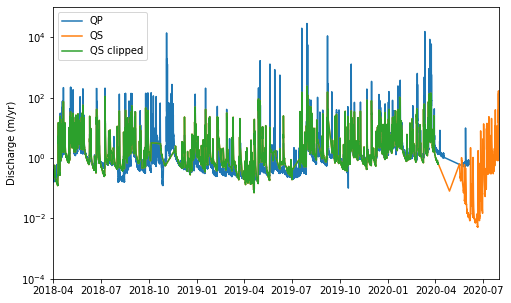

In [23]:
## compare QP and QS
plt.figure(figsize=(8,5))
plt.plot(discharge_QP['discharge(m/yr)'])
plt.plot(discharge_QS['discharge(m/yr)'])

plt.xlim([pd.Timestamp(2018,4,1),pd.Timestamp(2020,8,1)])
plt.ylim([1e-4,1e5])
plt.yscale('log')
plt.ylabel('Discharge (m/yr)')

# AFTER 4/6/2020, missing data and some anomalously low (orders of mangitude in QS) data
discharge_QP = discharge_QP.loc[discharge_QP.index<pd.Timestamp(2020,4,6)]
discharge_QS = discharge_QS.loc[discharge_QS.index<pd.Timestamp(2020,4,6)]
plt.plot(discharge_QS['discharge(m/yr)'])

plt.legend(['QP','QS','QS clipped'])

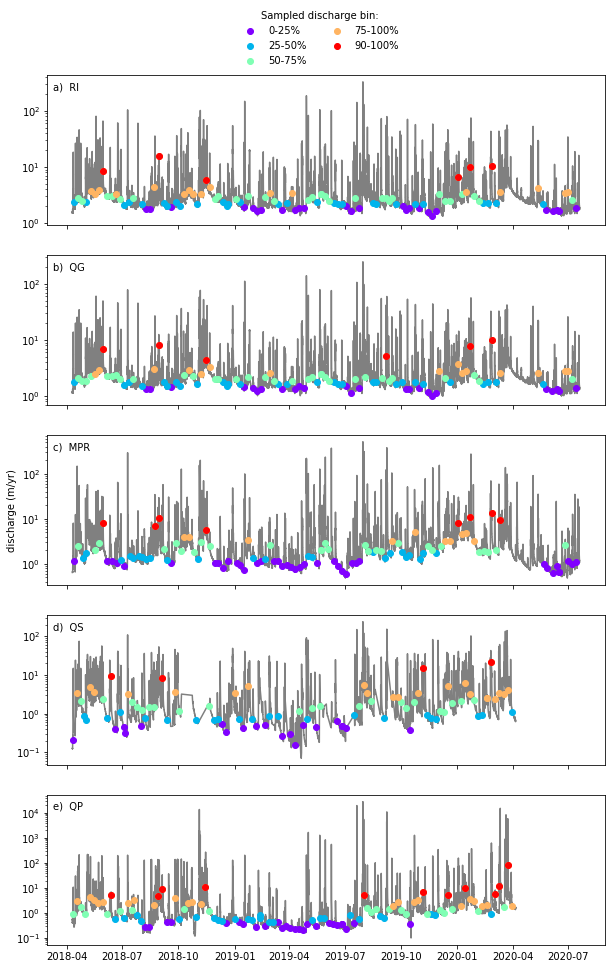

In [24]:
### match C and Q data, compute discharge statistics (ranks, bins)
# sites to iterate through
sitelist = ['RI','QG','MPR','QS','QP','Q3']
dflist = [discharge_RI,discharge_QG,discharge_MPR,discharge_QS,discharge_QP,discharge_Q3] # discharge datasets

#### initialize dataframes to put stuff into
cq = pd.DataFrame() # historical C-Q dataset (includes EDI data, USGS)
cq_sp = pd.DataFrame() # sp stands for sample period of this manuscript 2018-2020, includes isotopes
mediandf = pd.DataFrame(index=sitelist) # to put median discharge of different flow bins

## sampling period: samples from April 2018 - July 2020
startdate = pd.Timestamp(np.min(isotopes['datetime'].dt.date))
enddate = pd.Timestamp(np.max(isotopes['datetime'].dt.date))

#### initialize bin ranges for discharge. includes:
# quartiles plus top 10% 
# deciles plus 90-99% and 99-100% (a lot of storm samples in the top 1%)
# bottom 1, 2, and 5% (for identifying groundwater endmember in solute data)
binbottoms = [0,25,50,75,90]+[0,10,20,30,40,50,60,70,80,90,99]+[0,0,0]
bintops = [25,50,75,100,100]+[10,20,30,40,50,60,70,80,90,99,100]+[1,2,5]
binranges = zip(binbottoms,bintops)
binnames = [f'{b}-{t}' for b,t in binranges]
# that was for the big historical solute dataset. set smaller 2018-2020 datset (isotopes) bins separately
binbottoms_sp = [0,25,50,75,90]
bintops_sp = [25,50,75,100,100]

# intialize figure that shows discharge ranges for samples
fig,ax = plt.subplots(5,1,sharey=False,sharex=True,figsize=(10,16))
ax = ax.flatten()
colors = cm.get_cmap('rainbow', 5) 
letters = ['a) ','b) ','c) ','d) ','e) ','f) ','g) ','h) ','i) ']

for i,(site,discharge_temp) in enumerate(zip(sitelist,dflist)):
    
    # get the discharge dataset for this site
    discharge_temp = discharge_temp[~np.isnan(discharge_temp['discharge(m/yr)'])] # sometimes nans at 5 minute intervals in RI, messes up q matching
    
    # calculate rankings for discharge
    discharge_temp.insert(2,'rank',value=discharge_temp['discharge(m/yr)'].rank(pct=True)*100)

    # match solute records with nearest discharge record within 1 hour
    match = pd.merge_asof(
            solutes[solutes['Sample_ID']==site].set_index('datetime').sort_index(),
            discharge_temp,
            left_index=True,
            right_index=True,
            direction="nearest",
            tolerance=pd.Timedelta(hours=1)
        )
    # add to big cq dataset
    cq = pd.concat([cq,match])
    
    # calculate median flow for different bin ranges
    for j,(bottom,top) in enumerate(zip(binbottoms,bintops)):
        tempdischarge = discharge_temp[((discharge_temp['rank']<=top) & (discharge_temp['rank']>bottom))]
        
        # save to dataframe
        mediandf.loc[site,f'{bottom}-{top}'] = np.median(tempdischarge['discharge(m/yr)'])


    
    if site !='Q3': # site Q3 discharge record does not extend into our 2018-2020 sampling period, have to skip
        
        # refine discharge record to just sampling period
        discharge_temp_sp = discharge_temp[(discharge_temp.index>startdate) & (discharge_temp.index<enddate)]
        
        # calculate rankings for discharge
        discharge_temp_sp.insert(2,'rank_sp',value=discharge_temp_sp['discharge(m/yr)'].rank(pct=True)*100)

        # match to nearest 1 hour
        match_sp = pd.merge_asof(
                isotopes[isotopes['site']==site].set_index('datetime').sort_index(),
                discharge_temp_sp,
                left_index=True,
                right_index=True,
                direction="nearest",
                tolerance=pd.Timedelta(hours=1)
            )
        # add to dataset
        cq_sp = pd.concat([cq_sp,match_sp])

        # plot up dishcarge record for sample period
        ax[i].plot(discharge_temp_sp['discharge(m/yr)'],c='gray',label='_nolegend_')
        ax[i].set_yscale('log')
        
    # calculate median flow for different bin ranges
        for j,(bottom,top) in enumerate(zip(binbottoms_sp,bintops_sp)):
            tempdf = match_sp[((match_sp['rank_sp']<=top) & (match_sp['rank_sp']>bottom))]
            tempdischarge = discharge_temp_sp[((discharge_temp_sp['rank_sp']<=top) & (discharge_temp_sp['rank_sp']>bottom))]
            mediandf.loc[site,f'{bottom}-{top}_sp'] = np.median(tempdischarge['discharge(m/yr)'])
            
            # plot 
            ax[i].plot(tempdf.index,tempdf['discharge(m/yr)'],c=colors(j),ls='',marker='o')
            
        labeltext = letters[i]+' '+site
        ax[i].text(0.01,0.9,labeltext,transform = ax[i].transAxes)
        
ax[2].set_ylabel('discharge (m/yr)')
ax[0].legend(['0-25%','25-50%','50-75%','75-100%','90-100%'],title='Sampled discharge bin:',
              bbox_to_anchor=[0.33,1],frameon=False,ncol=2,fontsize=10)
fig.savefig('plots/FigS1_sampling.pdf')

# save dataframe: we will use the median Q for different bins later 
mediandf.to_csv('data/WRR2025_discharge_medians.csv')

In [25]:
## add the sites that don't have discharge data:
cq_sp = cq_sp.reset_index()
final_sp = pd.concat([cq_sp,isotopes.loc[~isotopes['site'].isin(['RI','QG','MPR','QS','QP']),:]])

In [26]:
# make a summary table showing the sampling period and sample number ### DO I EVEN USE THIS?
sitelist = ['RI','QG','MPR','Q3','QS','QP']

summarytable = pd.DataFrame(columns=['Sampling Period','Sample Number'])

for s in sitelist:
    temp = cq.loc[cq['Sample_ID']==s]
    temp = temp.loc[~np.isnan(temp['discharge(m/yr)']),:]
    
    tempdatemin = min(temp.index)
    tempdatemax = max(temp.index)#.astype(datetime).strftime('%Y.%m.%d')

    summarytable.loc[s,'Sampling Period'] = f"{datetime.strftime(tempdatemin, '%b %Y')} - {datetime.strftime(tempdatemax, '%b %Y')}"
    summarytable.loc[s,'Sample Number'] = len(temp)

In [27]:
# read in precipitation data from El Verde to match with precipitation samples
infile4  ="https://pasta.lternet.edu/package/data/eml/knb-lter-luq/14/470051/598db5118d7a0f04f154044fdbffeff6".strip() 
infile4  = infile4.replace("https://","http://")
precip_EV =pd.read_csv(infile4,parse_dates=['DATE'])

# for RP, precipitation data from nearby USGS rainfall gage at Altamira
precip_RP = nwis.get_record(sites='182350066063700', service='iv', start='2018-01-01', end='2020-07-01')[['00045']]
precip_RP.index = precip_RP.index.tz_convert('America/Puerto_Rico').tz_localize(None)
precip_RP.columns = ['rainfall(in)']

In [28]:
# match rainfall amounts for isotope data at El Verde
elverdesites = ['RCEV','WDEV','TCEV']
for s in elverdesites:

    tempdf = final_sp.loc[final_sp['site']==s]
    tempdf = tempdf.set_index('datetime')
    tempvol = precip_EV.set_index(['DATE']).loc[:, 'RAINFALL (MM)']

    for t in tempdf.index:
        code = tempdf.loc[t,'code']
        last = tempdf.loc[t,'datetime_last']
        daterange = [last,t]
        totalvol = np.sum(np.array(tempvol[daterange[0]:daterange[1]]))
        final_sp.loc[final_sp['code']==code,'rainfall(mm)'] = totalvol
        
        
# match rainfall amounts for isotope data at Rio Piedras
rpsites = ['RCRP','WDRP']
for s in rpsites:

    tempdf = final_sp.loc[final_sp['site']==s]
    tempdf = tempdf.set_index('datetime')
    tempvol = precip_RP.loc[:, 'rainfall(in)']

    for t in tempdf.index:
        code = tempdf.loc[t,'code']
        last = tempdf.loc[t,'datetime_last']
        daterange = [last,t]
        totalvol = np.sum(np.array(tempvol[daterange[0]:daterange[1]]))
        final_sp.loc[final_sp['code']==code,'rainfall(in)'] = totalvol

In [29]:
# add sampling period data into the bigger cq dataset
cq_export = cq.loc[cq.index<pd.Timestamp(2018,4,1),:].copy()
cq_export['site'] = cq_export['Sample_ID']

cq_export = pd.concat([cq_export,final_sp.set_index('datetime')])

# export matched data
cq_export.to_csv('data/WRR2025_cq.csv') # all cq data
final_sp.to_csv('data/WRR2025_cq_sp.csv') # sampling period only (2018-2020)